In [2]:
import numpy as np
from scipy import linalg
from numpy.linalg import norm

In [3]:
from dr import wda

In [4]:
def pair_tensor(T,x1,x2):
    temp=x1[:,None] - x2 
    C=temp*T[:,:,None]
    ans = np.tensordot(C, temp, ([0,1],[0,1]))
    return ans

def dist(x1, x2):
    """ Compute squared euclidean distance between samples (autograd)
    """
    x1p2 = np.sum(np.square(x1), 1)
    x2p2 = np.sum(np.square(x2), 1)
    return x1p2.reshape((-1, 1)) + x2p2.reshape((1, -1)) - 2 * np.dot(x1, x2.T)


def sinkhorn(w1, w2, M, reg, k):
    """Sinkhorn algorithm with fixed number of iteration (autograd)
    """
    K = np.exp(-M/reg )
    ui = np.ones((M.shape[0],), dtype=np.double)
    vi = np.ones((M.shape[1],), dtype=np.double)
    for i in range(k):
        vi = w2 / (np.dot(K.T, ui))
        ui = w1 / (np.dot(K, vi))
    G = ui.reshape((M.shape[0], 1)) * K * vi.reshape((1, M.shape[1]))
    return G


def split_classes(X, y):
    """split samples in X by classes in y
    """
    lstsclass = np.unique(y)
    return [X[y == i, :].astype(np.double) for i in lstsclass]



def wda_eig(X, y, p, reg, k, maxiter, P0):
    loss = []
    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    # compute uniform weighs
    wc = [np.ones((x.shape[0]), dtype=np.double) / x.shape[0] for x in xc]
    P=P0
    
    # pre-compute reg_c,c'
    regmean = np.zeros((len(xc), len(xc)))
    for i, xi in enumerate(xc):
        xi = np.dot(xi, P0)
        for j, xj in enumerate(xc[i:]):
            xj = np.dot(xj, P0)
            M = dist(xi, xj)
            regmean[i,j] = np.sum(M)/(len(xi)*len(xj))


    for it in range(maxiter):     
        
        loss_b = np.zeros((d,d))
        loss_w = np.zeros((d,d))
        for i, xi in enumerate(xc):
            pxi = np.dot(xi, P)
            for j, xj in enumerate(xc[i:]):
                pxj = np.dot(xj, P)
                M = dist(pxi, pxj)
                #G = sinkhorn(wc[i], wc[j + i], M, reg/regmean[i,j], 1)
                G = sinkhorn(wc[i], wc[j + i], M, reg, 1)
                if j==0:
                    loss_w += pair_tensor(G, xi, xj)
                else:
                    loss_b += pair_tensor(G, xi, xj)
        w, V = linalg.eig(loss_b+loss_b.T, loss_w+loss_w.T)
        w=np.real(w)
        V=np.real(V)

        idx = np.argsort(-w)
        Pnew = V[:, idx[0:p]]
        
        Pinv = np.linalg.inv(P.T.dot(P))
        Pninv = np.linalg.inv(Pnew.T.dot(Pnew))
        angle = np.linalg.norm((P.dot(Pinv.dot(P.T))-Pnew.dot(Pninv.dot(Pnew.T))),2)
        if it>0:
            loss.append(angle)
            #print("Iter: % 2d, angle: % 2.8f" %(it, angle))
        
        P=Pnew
        if (abs(angle)< 1e-6):
            break

    Popt = P

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj, loss

In [5]:
n = 1000  # nb samples in source and target datasets
nz = 0.2

np.random.seed(1)

# generate circle dataset
t = np.random.rand(n) * 2 * np.pi
ys = np.floor((np.arange(n) * 1.0 / n * 3)) + 1
xs = np.concatenate(
    (np.cos(t).reshape((-1, 1)), np.sin(t).reshape((-1, 1))), 1)
xs = xs * ys.reshape(-1, 1) + nz * np.random.randn(n, 2)

t = np.random.rand(n) * 2 * np.pi
yt = np.floor((np.arange(n) * 1.0 / n * 3)) + 1
xt = np.concatenate(
    (np.cos(t).reshape((-1, 1)), np.sin(t).reshape((-1, 1))), 1)
xt = xt * yt.reshape(-1, 1) + nz * np.random.randn(n, 2)

nbnoise = 8

xs = np.hstack((xs, np.random.randn(n, nbnoise)))
xt = np.hstack((xt, np.random.randn(n, nbnoise)))

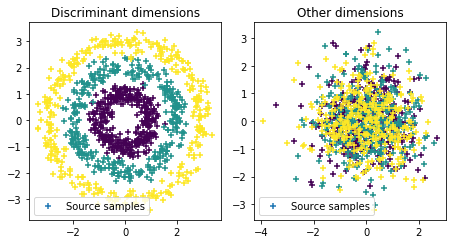

In [6]:
## plot data
import matplotlib.pylab as pl
%matplotlib inline

pl.figure(1, figsize=(6.4, 3.5))

pl.subplot(1, 2, 1)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, marker='+', label='Source samples')
pl.legend(loc=0)
pl.title('Discriminant dimensions')

pl.subplot(1, 2, 2)
pl.scatter(xt[:, 2], xt[:, 3], c=yt, marker='+', label='Source samples')
pl.legend(loc=0)
pl.title('Other dimensions')
pl.tight_layout()

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA 
#%% Compare the accuracy and prob. of convergence
p=2 # dimension of subspace
d=xs.shape[1]
k=10 # sinkhorn iteration number
maxiter=1000
reg=5.0 
acclist_wda = []
acclist_eig = []

converged_wda = 0 
converged_eig = 0

for rep in range(100):
    x0=np.random.randn(d,p) # random init
    P0, r = np.linalg.qr(x0)
    
    ## train
    Pwda, projwda, loss = wda_eig(xs, ys, 2, reg, 10, 100, P0)
    #Pwda, projwda, loss = wda_eig(xs, ys, 2, reg,P0, k=10, maxiter=100, verbose = 0)   
    model = KNeighborsClassifier(n_neighbors=10)
    model.fit(projwda(xs),ys)
    
    ## test
    predicted= model.predict(projwda(xt)) 
    acc = accuracy_score(yt, predicted)
    if (acc>0.9):
        converged_eig = converged_eig+1
    acclist_eig.append(acc)
    
    Pwda2, projwda2 = wda(xs, ys, p=2, reg=reg, k=10, solver=None, maxiter=100, verbose=0, P0=P0)
    model = KNeighborsClassifier(n_neighbors=10)
    model.fit(projwda2(xs), ys)
    
    predicted2 = model.predict(projwda2(xt))
    acc2 = accuracy_score(yt, predicted2)
    if (acc2>0.9):
        converged_wda = converged_wda+1
    acclist_wda.append(acc2)
    


In [9]:
print('WDA mean:', np.mean(acclist_wda), ' std:', np.std(acclist_wda), ' converged trials:', converged_wda)

WDA mean: 0.7625800000000003  std: 0.19276675958266248  converged trials: 44


In [10]:
print('WDA-eig mean:', np.mean(acclist_eig), ' std:', np.std(acclist_eig), ' converged trials:', converged_eig)

WDA-eig mean: 0.9730000000000001  std: 1.1102230246251565e-16  converged trials: 100
